# Gamma Ray Bursts

Let's look at the latest database of Gamma Ray Bursts.

- The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
- You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html

This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. Be creative! You're discovering

Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed?

In [150]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.visualization import hist

from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks

from sklearn.mixture import GaussianMixture
from scipy.optimize import fsolve
from scipy.stats import gaussian_kde
from scipy.optimize import brentq

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from scipy.stats import norm

In [106]:
# Kernel Density Estimation
def kde_sklearn(data, bandwidth, xgrid):
    kde_skl = KernelDensity(bandwidth=bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis])  # usa xgrid passato come argomento
    return np.exp(log_pdf)

# Difference betwwn two KDE
def kde_diff(x): return kde0(x)*w0 - kde1(x)*w1

# Gaussian distribution
def gaussian_pdf(x, mean, std, weight):
    return weight * (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean)/std)**2)

# Intersection points of tho Gaussian Distribution
def diff(x):
    return gaussian_pdf(x, means[0], stds[0], weights[0]) - gaussian_pdf(x, means[1], stds[1], weights[1])



In [107]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str', unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

# Check the data
print("Data names: ", names)
print("Data shape: ", data.shape)

Data names:  ['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']
Data shape:  (15, 8858)


/tmp/ipykernel_2703/3300681567.py:7: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("Summary_table.txt", dtype='str', unpack='True')


In [ ]:
# Extract the variable 

# Right ascension in J2000 coordinates. If the GRB was observed by multiple instruments, the localisation with the smallest angular uncertainty is used.
ra_s = data[names=='ra'][0].astype(float)

# Declination in J2000 coordinates. If the GRB was observed by multiple instruments, the localisation with the smallest angular uncertainty is used.
decl_s = data[names=='decl'][0].astype(float)

# 1σ error on the localisation. A 2d Gaussian pdf is assumed, implying that the probability that the true position of the GRB lies within 1σ degrees is ~39.3%.
pos_error_s = data[names=='pos_error'][0].astype(float)

# Duration of the time interval during which 90% of the GRB photon counts are observed, starting at 5% and ending at 95%. This parameter depends on the efficiency with which photons of various energies can be observed, making the T90 dependent on the detector.
T90_s = data[names=='T90'][0].astype(float)
# Estimated 1σ error on the duration of the T90 interval.
T90_error_s = data[names=='T90_error'][0].astype(float)

# The time integrated total energy per unit surface. Please note that the observed value strongly depends on the energy band and thus the detector that observed the burst.
# - For the Fermi-GBM detector, the energy band is 10-1000 keV.
# - For the Swift (BAT) detector, the energy band is 15-150 keV.
# - For the BeppoSAX detector, the energy band is 40-700 keV.
# - For the BATSE detector, the energy band is 20-300 keV.
fluence_s = data[names=='fluence'][0].astype(float)
# Estimated 1σ error on the fluence.
fluence_error_s = data[names=='fluence_error'][0].astype(float)

# Distance to the GRB.
z_s = data[names=='redshift'][0].astype(float)

# mask unphysical values
T90 = T90_s[T90_s>0]
z = z_s[z_s>0]
fluence = fluence_s[fluence_s>0]

## Sky Map

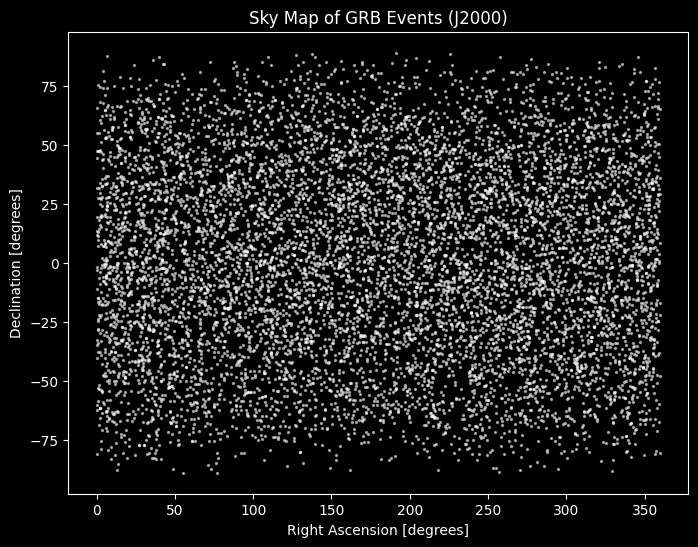

In [160]:
plt.figure(figsize=(8,6))
plt.style.use('dark_background')  
plt.scatter(ra_s, decl_s, color='white', s=2, alpha=0.5)
plt.title('Sky Map of GRB Events (J2000)', color='white')
plt.xlabel('Right Ascension [degrees]', color='white')
plt.ylabel('Declination [degrees]', color='white')
plt.show()

plt.style.use('default') # Remove dark_background from future plot

## 1-D Distributions

I here report the 1-dimensional distribution of the three variables I decided to study: redshift, fluence and time.

I will then apply some statistics to see if I can catch some of the features of these curves, and link them to the physics of gamma ray bursts.

### Redshift

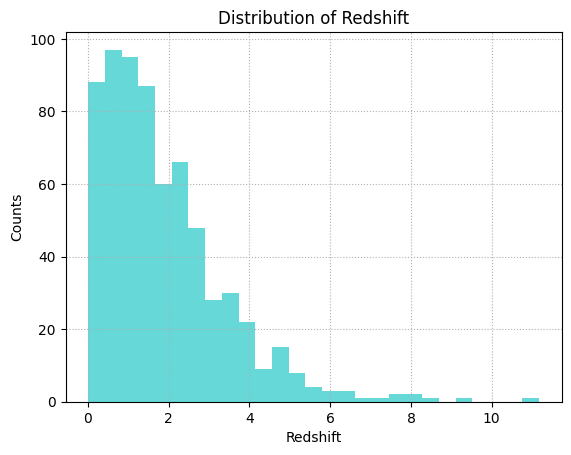

In [ ]:
hist(z, bins='freedman', color='c', alpha =0.6)
plt.title('Distribution of Redshift')
plt.xlabel('Redshift')
plt.ylabel('Counts')
plt.grid(linestyle=':')
plt.show()

In [111]:
# Find the best bandwidth for KDE
bwrange = np.linspace(0.01, 1, 40) # Test 40 bandwidths from 0.01 to 1.0

K = 5 # Do 5-fold cross validation

grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(z[:, None]) #Fit the histogram data 
bw_opt = grid.best_params_['bandwidth'] 

print(bw_opt)

0.4923076923076923


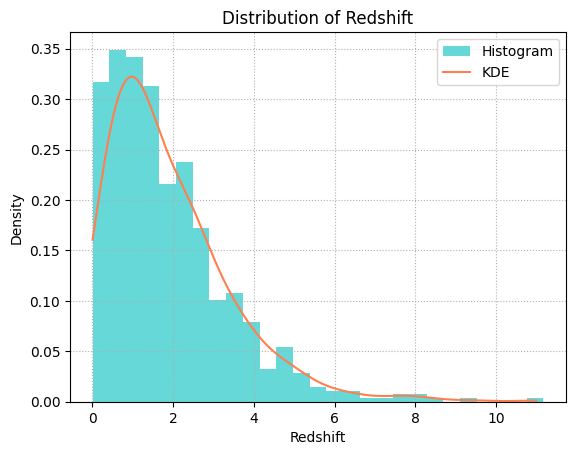

In [ ]:
# Kernel Density Estimation
xgrid =np.linspace(z.min(), z.max(), 1000)
pdf = kde_sklearn(z, bandwidth=bw_opt, xgrid=xgrid)

# Plot
hist(z, bins='freedman', color='c', density= True,alpha =0.6, label='Histogram')
plt.plot(xgrid, pdf, color='coral', label = 'KDE')
plt.title('Distribution of Redshift')
plt.xlabel('Redshift')
plt.ylabel('Density')
plt.legend()
plt.grid(linestyle=':')
plt.show()

In [113]:
# Redshift peaks
peaks_z, _ = find_peaks(pdf)

print(f"Number of peaks found for redshift: {len(peaks_z)}")
print(f"Peaks at values of redshift (log10): {xgrid[peaks_z]}")

Number of peaks found for redshift: 3
Peaks at values of redshift (log10): [ 0.97672022  7.67724424 10.9889975 ]


### Fluence and Time

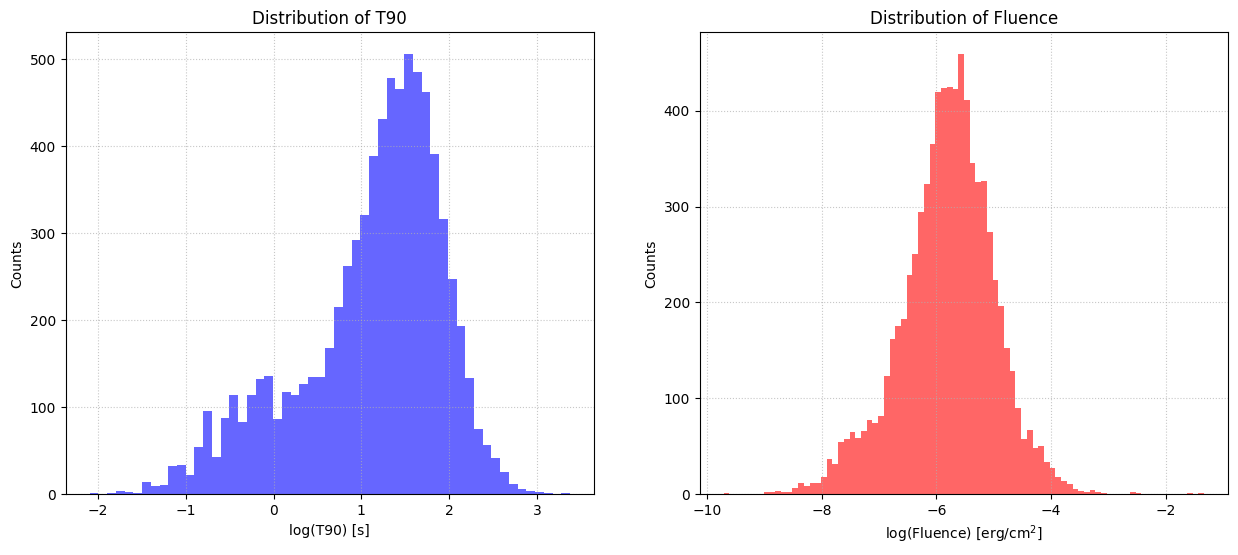

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First histogram: T90
hist(np.log10(T90), bins='freedman', color='blue', alpha=0.6, ax=ax1)
ax1.set_title('Distribution of T90')
ax1.set_xlabel('log(T90) [s]')
ax1.set_ylabel('Counts')
ax1.grid(True, linestyle=':', alpha=0.7)

# Second histogram: fluence
hist(np.log10(fluence), bins='freedman', color='red', alpha=0.6, ax=ax2)
ax2.set_title('Distribution of Fluence')
ax2.set_xlabel(r'log(Fluence) [erg/cm$^2$]')
ax2.set_ylabel('Counts')
ax2.grid(True, linestyle=':', alpha=0.7)

plt.show()

In [115]:
# Find the best bandwidth for KDE
bwrange = np.linspace(0.01, 0.5, 20) # Test 20 bandwidths from 0.01 to 0.5

K = 5 # Do 5-fold cross validation

X_f = np.log10(fluence[:, None])
X_t = np.log10(T90[:, None])

bw_opt_arr = []

for X in [X_f, X_t]:

    grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
    grid.fit(X) #Fit the histogram data 

    bw_opt_arr.append(grid.best_params_['bandwidth'])
    
print(np.array(bw_opt_arr))

[0.29368421 0.11315789]


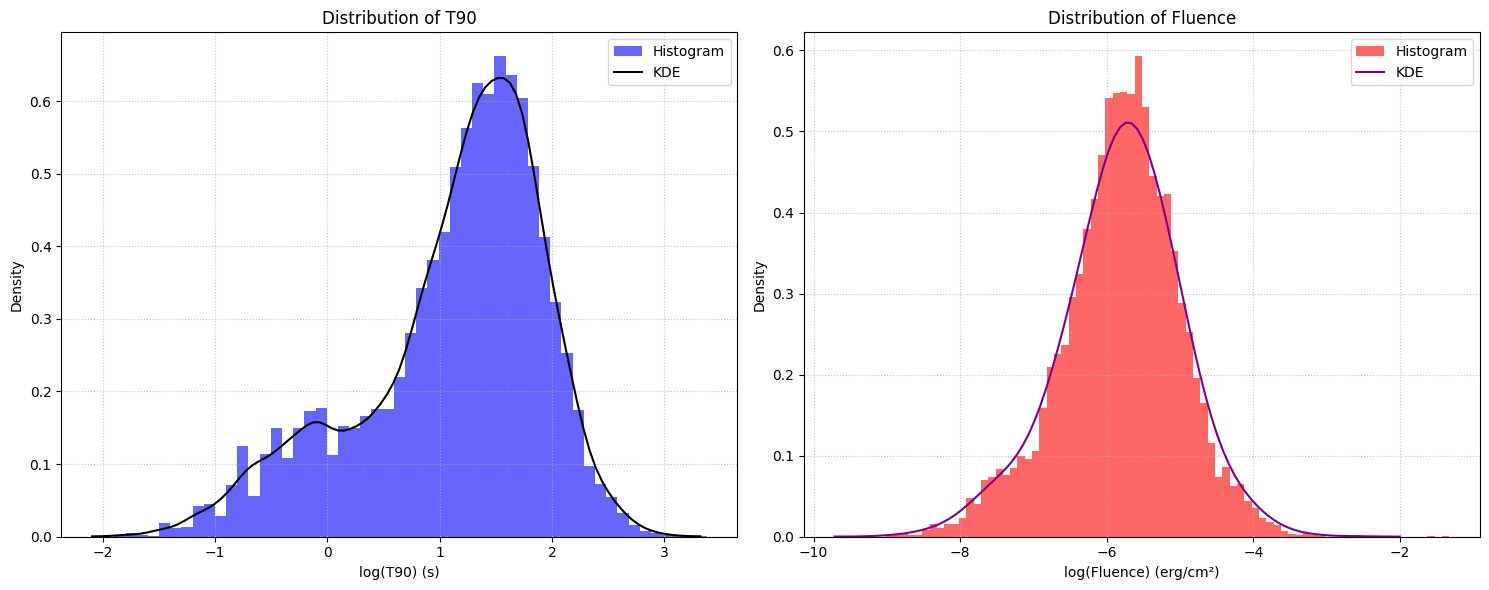

In [116]:
# Kernel Density Estimation
# T90
logT90 = np.log10(T90)
xgrid1 = np.linspace(logT90.min(), logT90.max(), 100)  # scala lineare nello spazio log
pdf1 = kde_sklearn(logT90, bandwidth=bw_opt_arr[1], xgrid=xgrid1)

# Fluence
logfluence = np.log10(fluence)
xgrid2 = np.linspace(logfluence.min(), -2, 100)
pdf2 = kde_sklearn(logfluence, bandwidth=bw_opt_arr[0], xgrid=xgrid2)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First histogram: T90
hist(logT90, bins='freedman', color='blue', density=True, alpha=0.6, label='Histogram', ax=ax1)
ax1.plot(xgrid1, pdf1, label='KDE', color='black')
ax1.set_title('Distribution of T90')
ax1.set_xlabel('log(T90) (s)')
ax1.set_ylabel('Density')
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend()

# Second histogram: fluence
hist(logfluence, bins='freedman', color='red', density=True, alpha=0.6, label='Histogram', ax=ax2)
ax2.plot(xgrid2, pdf2, label='KDE', color='purple')
ax2.set_title('Distribution of Fluence')
ax2.set_xlabel('log(Fluence) (erg/cm²)')
ax2.set_ylabel('Density')
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend()

plt.tight_layout()
plt.show()

In [117]:
peaks_T90, _ = find_peaks(pdf1)
peaks_fluence, _ = find_peaks(pdf2)

# T90 peaks
print(f"Number of peaks found for T90: {len(peaks_T90)}")
print("Peaks at T90:")
for val in 10**xgrid1[peaks_T90]:
    print(f"  • {val:.2f} s")

# Fluence peaks
print(f"\nNumber of peaks found for Fluence: {len(peaks_fluence)}")
print("Peaks at Fluence:")
for val in 10**xgrid2[peaks_fluence]:
    print(f"  • {val:.2e}")

Number of peaks found for T90: 2
Peaks at T90:
  • 0.85 s
  • 32.80 s

Number of peaks found for Fluence: 1
Peaks at Fluence:
  • 1.82e-06


From these plots, I can see that there seem to be one type of bursts in terms of the fluence, while there are two distinct populations of bursts in terms of the duration. I will try to inverstigate this hypothesis using the clustering methods.

### $T_{90}$ Clustering

From the KDE it seems that only $\log T_{90}$ has an evident bimodality, so I decide to investigate only this shape trying to use a clustering algorithm.

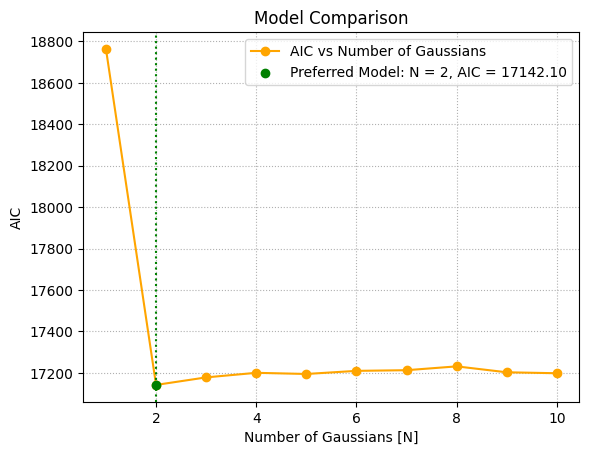

In [118]:
AIC = []
n_components = np.arange(1, 11)

for i in n_components:
    model = GaussianMixture(i)
    model.fit(X_t)
    aic = model.aic(X_t)
    AIC.append(aic)

AIC = np.array(AIC)
n_best_index = np.argmin(AIC)
n_best = n_components[n_best_index]
best_aic = AIC[n_best_index] 

plt.plot(n_components, AIC, color='orange', marker='o', label = "AIC vs Number of Gaussians")
plt.scatter(n_best, best_aic, color='g', label=f"Preferred Model: N = {n_best}, AIC = {best_aic:.2f}", zorder=5)
plt.axvline(n_best, linestyle=':', color='g')
plt.title("Model Comparison")
plt.xlabel("Number of Gaussians [N]")
plt.ylabel("AIC")
plt.legend()
plt.grid(linestyle = ":")
plt.show()


This plot confirms my hypothesis $\log T_{90}$ distribution bymodality.

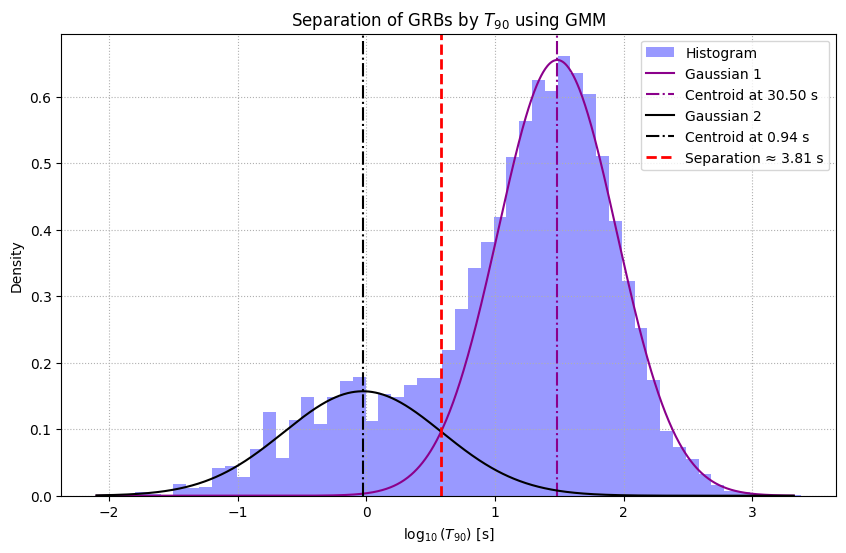

Separation point: 3.813 s


In [119]:
# Gaussian Mixture
n_clusters = 2
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(X_t)
labels = gmm.predict(X_t)

# Single Gaussian distribution
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())
weights = gmm.weights_

# Intersection point
x_intersection = fsolve(diff, x0=(means[0] + means[1]) / 2)[0]

# Plot
xgrid = np.linspace(logT90.min(), logT90.max(), 1000).reshape(-1,1)
colors = ["darkmagenta", "black"]

plt.figure(figsize=(10,6))

# Histogram
hist(logT90, bins='freedman', color='blue', density=True, alpha=0.4, label='Histogram')
# Gaussians
for i in range(n_clusters):
    mean = means[i]
    std = stds[i]
    weight = weights[i]
    
    gaussian = weight * (1/(std*np.sqrt(2*np.pi))) * np.exp(-0.5*((xgrid.flatten()-mean)/std)**2)
    plt.plot(xgrid, gaussian, color=colors[i], label=f'Gaussian {i+1}')
    plt.axvline(mean, color=colors[i], linestyle='-.', label=f'Centroid at {10**mean:.2f} s')
# Intersection point 
plt.axvline(x_intersection, color='red', linestyle='--', linewidth=2, label=f'Separation ≈ {10**x_intersection:.2f} s')

plt.xlabel(r'$\log_{10}(T_{90})$ [s]')
plt.ylabel('Density')
plt.title(r'Separation of GRBs by $T_{90}$ using GMM')
plt.legend()
plt.grid(linestyle=":")
plt.show()

print("Separation point:", f'{10**x_intersection:.3f} s')

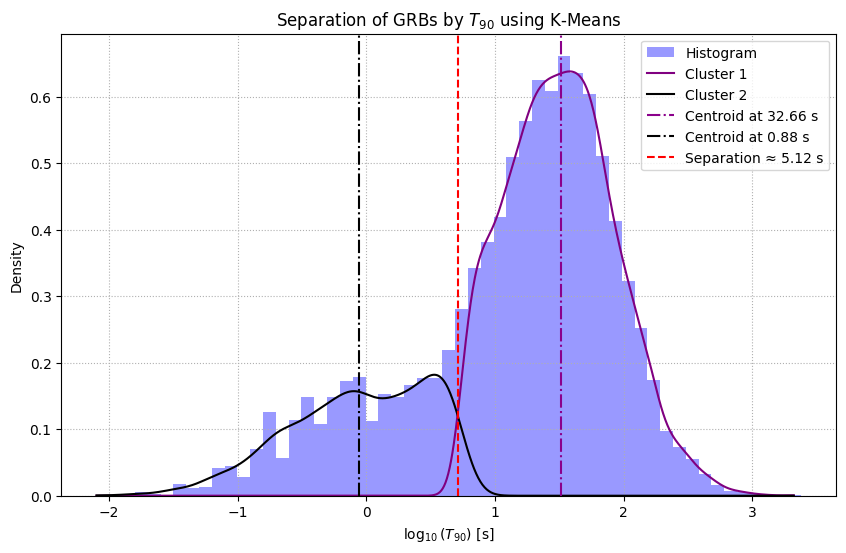

Separation point: 5.119 s


In [120]:
# K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_t)
labels = kmeans.labels_
Y_t = kmeans.predict(X_t)

centroids = kmeans.cluster_centers_.flatten()

# Log-transformed data
logT90_0 = np.log10(T90[Y_t == 0])
logT90_1 = np.log10(T90[Y_t == 1])

# Proportional weights
w0 = len(logT90_0) / len(logT90)
w1 = len(logT90_1) / len(logT90)

# KDEs
kde0 = gaussian_kde(logT90_0)
kde1 = gaussian_kde(logT90_1)

# Separation line
separation_log = brentq(kde_diff, min(logT90), max(logT90))
separation_kmeans = 10**separation_log

# Plot
x_vals = np.linspace(min(logT90), max(logT90), 1000)
colors = ["darkmagenta", "black"]

plt.figure(figsize=(10,6))

# Histogram
hist(logT90, bins='freedman', color='blue', density=True, alpha=0.4, label='Histogram')
# Weighted KDE
plt.plot(x_vals, kde0(x_vals)*w0, color='purple', label='Cluster 1')
plt.plot(x_vals, kde1(x_vals)*w1, color='black', label='Cluster 2')
# Centroids
for i in range(n_clusters):
    centroid = centroids[i]
    plt.axvline(centroid, linestyle='-.', color=colors[i], label=f'Centroid at {10**centroid:.2f} s')
# Separation line
plt.axvline(separation_log, color='red', linestyle='--', label=f'Separation ≈ {separation_kmeans:.2f} s')

plt.xlabel(r'$\log_{10}(T_{90})$ [s]')
plt.ylabel('Density')
plt.title(r'Separation of GRBs by $T_{90}$ using K-Means')
plt.legend()
plt.grid(True, linestyle=":")
plt.show()

print("Separation point:", f'{separation_kmeans:.3f} s')

From this initial analysis I learning two main things:

1. the variable that shows the multi-modality more evidently is $T_{90}$, while redshift and fluence see to have just one mode;

2. the two clustering methods I used, Gaussian Mixture and K-Means, returned quite different results.

## 2-D Distrubutions

In this section I'd like to test if I could study the bimodality in the 2-dimensional space.

I decide to concentrate my analysis on the plot $\log T_{90}$ vs. $\log f$, indeed in this way I have a log-log plot, but I could have easily chosen also $z$ vs. $\log T_{90}$.

In [136]:
# Data selection (T_90 and Fluence have to be both not zero now)
mask = np.logical_and(T90_s>0, fluence_s>0)
fluence_corr = fluence_s[mask]
T90_corr = T90_s[mask]

# Store the data in a matrix
matrix_val = np.array((np.log10(T90_corr), np.log10(fluence_corr)))
f_vs_t90 = matrix_val.transpose()

# Prepare 2D feature space: log10(T90) and log10(Fluence)
X_2D = np.column_stack((np.log10(T90_corr), np.log10(fluence_corr)))

# Compute 2D histogram (density)
H, xedges, yedges = np.histogram2d(X_2D[:, 0], X_2D[:, 1], bins=50)

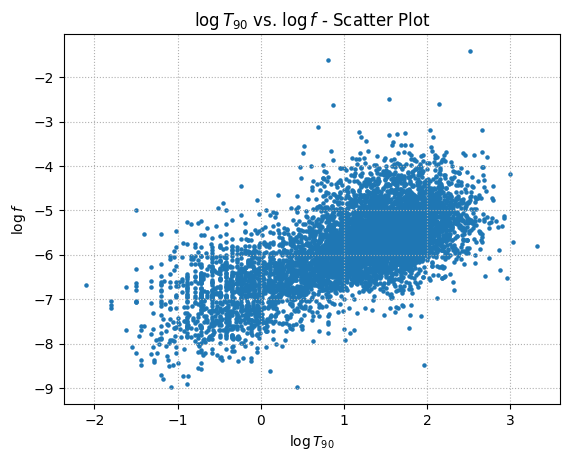

In [126]:
plt.scatter(np.log10(T90_corr), np.log10(fluence_corr), s=5)
plt.xlabel(r'$\log T_{90}$')
plt.ylabel(r'$\log f$')
plt.title(r'$\log T_{90}$ vs. $\log f$ - Scatter Plot')
plt.grid(linestyle = ':')
plt.show()

### K-Means

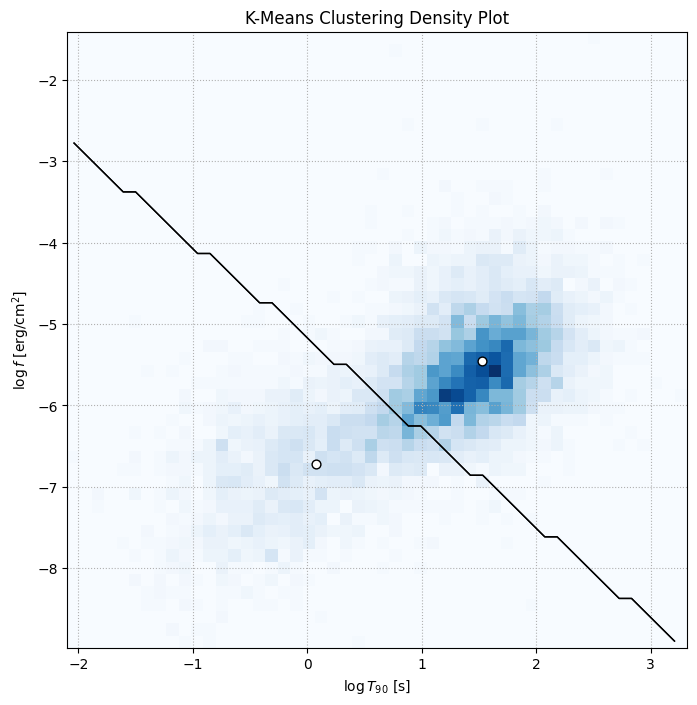

In [139]:
# K-Means clustering
n_clusters = 2
k_means = KMeans(n_clusters=n_clusters, random_state=42)
labels = k_means.fit_predict(X_2D)
cluster_centers = k_means.cluster_centers_

# Compute grid centers
x_centers = 0.5 * (xedges[:-1] + xedges[1:])
y_centers = 0.5 * (yedges[:-1] + yedges[1:])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape(2, 50*50).T

# Predict cluster labels for grid points
Z = k_means.predict(Xgrid).reshape(50, 50)

# Plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

# Density background
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
          cmap='Blues')
# Cluster centerss
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=40, c='w', edgecolors='k')
# Cluster boundaries as contour lines
for i in range(n_clusters):
    Hcp = (Z == i).astype(int)
    ax.contour(x_centers, y_centers, Hcp, levels=[0.5], colors='k', linewidths=1)

ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])
ax.set_xlabel(r"$\log{T_{90}}$ [s]")
ax.set_ylabel(r"$\log{f}$ [erg/cm$^2$]")
ax.set_title("K-Means Clustering Density Plot")

plt.grid(linestyle=':')
plt.show()

In [178]:
# Extract centroids from log10 space
logT90_centroids = cluster_centers[:, 0]

# Find the midpoint in log space
logT90_threshold = np.mean(logT90_centroids)

# Convert to linear T90
T90_threshold = 10**logT90_threshold

print(f"Estimated T90 separation threshold: {T90_threshold:.3f} s (log10: {logT90_threshold:.3f})")

Estimated T90 separation threshold: 6.303 s (log10: 0.800)


### Mean Shift

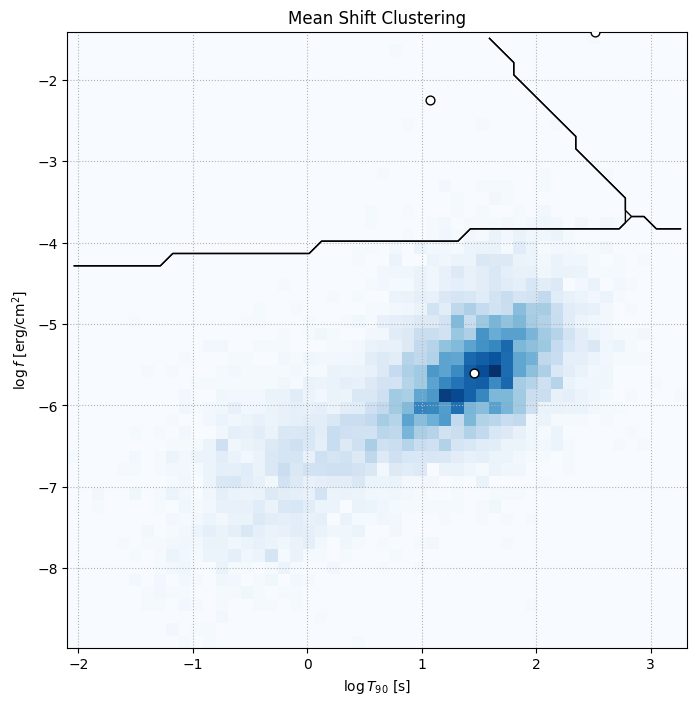

In [140]:
# Estimate bandwidth
bandwidth = estimate_bandwidth(X_2D)

# Mean Shift Fit
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
labels = ms.fit_predict(X_2D)
centroids = ms.cluster_centers_

# Count points per cluster
labels_unique = np.unique(labels)
counts_tot = np.array([list(labels).count(u) for u in labels_unique])
n_clusters = np.sum(counts_tot > 1)

# Grid for contour prediction
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])
Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid_flat = np.array(Xgrid).reshape((2, -1)).T
H_pred = ms.predict(Xgrid_flat).reshape((50, 50))

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

# Density background
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
          cmap='Blues')
# Contours for each cluster (if more than 1 point)
for i in range(len(centroids)):
    if counts_tot[i] > 1:
        mask = (H_pred == i).astype(int)
        ax.contour(x_centers, y_centers, mask, levels=[0.5],
                   linewidths=1, colors='k')
# Centroids
for i, (x, y) in enumerate(centroids):
    color = 'white' if counts_tot[i] > 1 else 'red'
    ax.scatter(x, y, s=40, c=color, edgecolors='k', zorder=5)

ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])
ax.set_xlabel(r"$\log{T_{90}}$ [s]")
ax.set_ylabel(r"$\log{f}$ [erg/cm$^2$]")
ax.set_title("Mean Shift Clustering")

plt.grid(linestyle=':')
plt.show()

Here, we see how the behaviour is different. Apparently, the algorithm sees only one center in the bulge, and associates it with one of the three identified clusters' centres. I will try to change the bandwidth to see if anything improves.

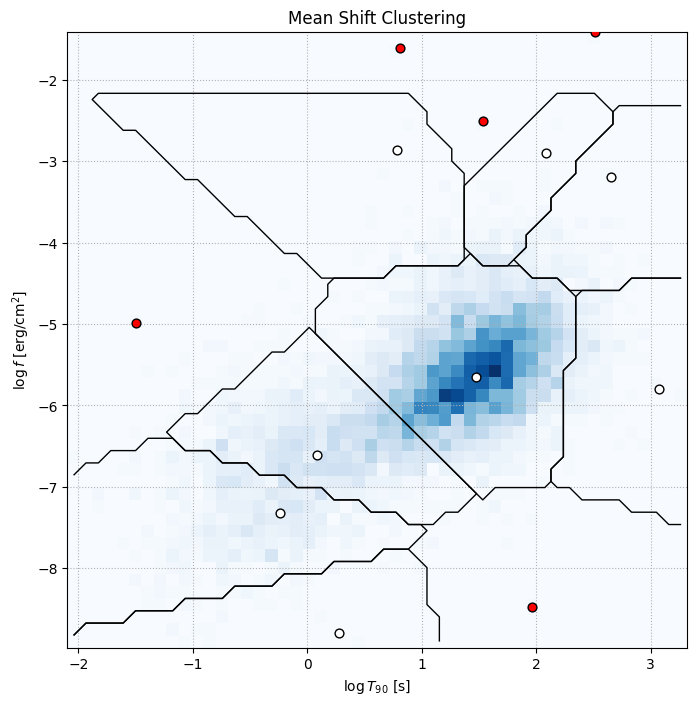

In [141]:
# Mean Shift Fit
ms = MeanShift(bandwidth=0.4, bin_seeding=True, cluster_all=False)
labels = ms.fit_predict(X_2D)
centroids = ms.cluster_centers_

# Count points per cluster
labels_unique = np.unique(labels)
counts_tot = np.array([list(labels).count(u) for u in labels_unique])
n_clusters = np.sum(counts_tot > 1)

# Grid for contour prediction
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])
Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid_flat = np.array(Xgrid).reshape((2, -1)).T
H_pred = ms.predict(Xgrid_flat).reshape((50, 50))

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

# Density background
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
          cmap='Blues')
# Contours for each cluster (if more than 1 point)
for i in range(len(centroids)):
    if counts_tot[i] > 1:
        mask = (H_pred == i).astype(int)
        ax.contour(x_centers, y_centers, mask, levels=[0.5],
                   linewidths=1, colors='k')
# Centroids
for i, (x, y) in enumerate(centroids):
    color = 'white' if counts_tot[i] > 1 else 'red'
    ax.scatter(x, y, s=40, c=color, edgecolors='k', zorder=5)

ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])
ax.set_xlabel(r"$\log{T_{90}}$ [s]")
ax.set_ylabel(r"$\log{f}$ [erg/cm$^2$]")
ax.set_title("Mean Shift Clustering")

plt.grid(linestyle=':')
plt.show()

The red centroids are the **singletons**. I hoped to see that mostly the algorithm was able to find two "real" centroids and the others were just resulting from the outliers effect on the gradient. Instead, I proved that, in this case, the algorithm fails to find a suitable number of clusters.

### Gaussian Mixture

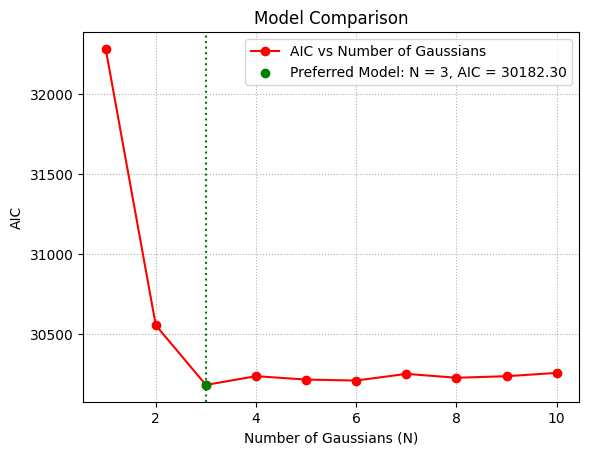

In [142]:
AIC = []
n_components = np.arange(1,11)

for i in n_components:
    model = GaussianMixture(i)
    model.fit(f_vs_t90)
    aic = model.aic(f_vs_t90)
    AIC.append(aic)

AIC = np.array(AIC)
n_best_index = np.argmin(AIC)
n_best = n_components[n_best_index]
best_aic = AIC[n_best_index] 

plt.plot(n_components, AIC, color='red', marker='o', label = "AIC vs Number of Gaussians")
plt.scatter(n_best, best_aic, color='green', label=f"Preferred Model: N = {n_best}, AIC = {best_aic:.2f}", zorder=5)
plt.axvline(n_best, color='green', linestyle=':')
plt.title("Model Comparison")
plt.xlabel("Number of Gaussians (N)")
plt.ylabel("AIC")
plt.legend()
plt.grid(linestyle = ":")
plt.show()

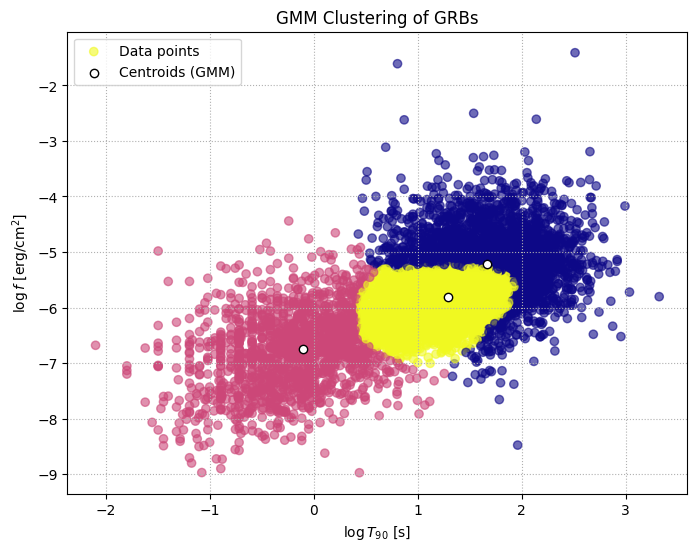

In [ ]:
# Gaussian Mixture with 3 components
gmm = GaussianMixture(n_components=n_best, random_state=42)
gmm.fit(f_vs_t90)
c_gmm = gmm.predict(f_vs_t90)
centroids_gmm = gmm.means_

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(np.log10(T90_corr), np.log10(fluence_corr), c=c_gmm, cmap='plasma', alpha=0.6, label='Data points')
plt.scatter(centroids_gmm[:, 0], centroids_gmm[:, 1], c='white', marker='o', edgecolors='k', label='Centroids (GMM)')
plt.xlabel(r"$\log{T_{90}}$ [s]")
plt.ylabel(r"$\log{f}$ [erg/cm$^2$]")
plt.title('GMM Clustering of GRBs')
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

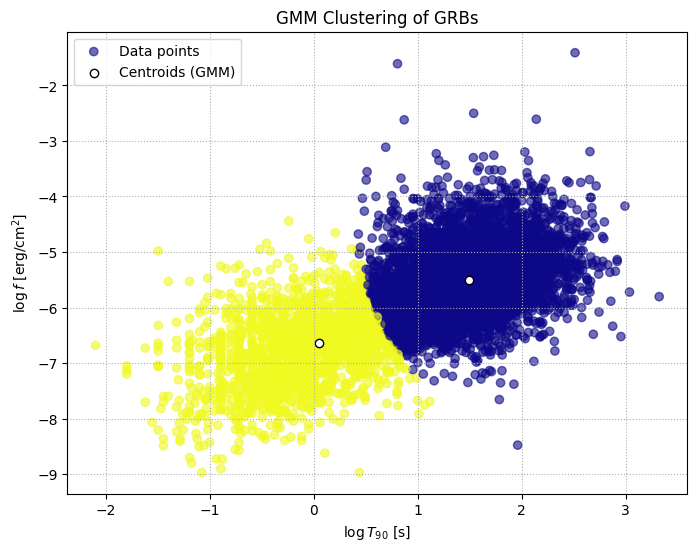

In [149]:
# Gaussian Mixture with 2 components
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(f_vs_t90)
c_gmm = gmm.predict(f_vs_t90)
centroids_gmm = gmm.means_

plt.figure(figsize=(8, 6))
plt.scatter(np.log10(T90_corr), np.log10(fluence_corr), c=c_gmm, cmap='plasma', alpha=0.6, label='Data points')
plt.scatter(centroids_gmm[:, 0], centroids_gmm[:, 1],
            c='white', marker='o', edgecolors='k', label='Centroids (GMM)')
plt.xlabel(r"$\log{T_{90}}$ [s]")
plt.ylabel(r"$\log{f}$ [erg/cm$^2$]")
plt.title('GMM Clustering of GRBs')
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

In [152]:
# Extract parameters of the Gaussians in log10(T90) space
means = gmm.means_[:, 0]              # log10(T90) means
stds = np.sqrt(gmm.covariances_[:, 0, 0])  # std devs for log10(T90)
weights = gmm.weights_                # mixing weights

# Sort components for consistent interpretation
order = np.argsort(means)
mu1, mu2 = means[order]
sigma1, sigma2 = stds[order]
w1, w2 = weights[order]

def mixture_diff(x):
    p1 = w1 * norm.pdf(x, mu1, sigma1)
    p2 = w2 * norm.pdf(x, mu2, sigma2)
    return p1 - p2

# Initial guess near the midpoint
x0 = (mu1 + mu2) / 2

# Solve using fsolve
boundary_log_t90 = fsolve(mixture_diff, x0)[0]
boundary_t90 = 10 ** boundary_log_t90

print(f"Decision boundary (log10 T90): {boundary_log_t90:.3f}")
print(f"Decision boundary (T90): {boundary_t90:.3f} s")

Decision boundary (log10 T90): 0.632
Decision boundary (T90): 4.283 s


## Physics Perspective

The analysis suggests the presence of two distinct groups of gamma-ray bursts, distinguished primarily by their duration. Other features appear to follow a more unimodal distribution. 

Literature supports this observation: gamma-ray bursts are typically classified into two categories based on duration:

- Long GRBs, with an average duration around 30 seconds
- Short GRBs, with an average duration around 0.3 seconds

A commonly accepted boundary between the two is approximately 2 seconds.

## Algorithmic Perspective

Among the clustering methods I tried, **Mean Shift** turned out to be the most sensitive to outliers. It often detected too many clusters, likely because it uses a method that looks at the density of nearby points. When some points are far away from the others, they can still affect this density calculation and cause the algorithm to find extra, unnecessary clusters.

## Errors Discussion

So far I didn't mention anything concerning the errors in data.

Now, I'm going to check if that affects my analysis or not.

In [158]:
# Select the errors data
mask = np.logical_and(T90_s>0, fluence_s>0)
fluence_err_corr = fluence_error_s[mask]
T90_err_corr = T90_error_s[mask]

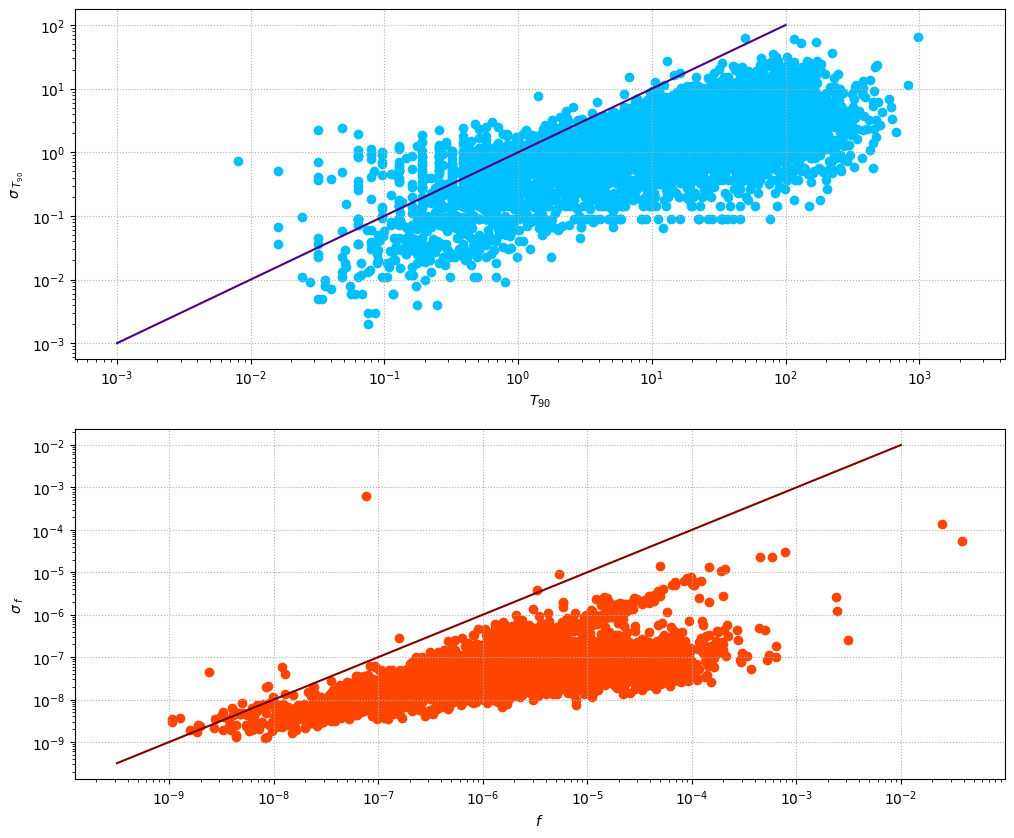

In [177]:
xgrid_t = np.logspace(-3, 2, 4) 
xgrid_f = np.logspace(-9.5, -2, 4)

fig, ax = plt.subplots(2, figsize=(12, 10))

ax[0].scatter(T90_corr, T90_err_corr, color='deepskyblue')
ax[0].plot(xgrid_t, xgrid_t, '-', c='indigo')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('$T_{90}$')
ax[0].set_ylabel('$\sigma_{\ T_{90}}$')
ax[0].grid(linestyle = ':')

ax[1].scatter(fluence_corr, fluence_err_corr, color='orangered')
ax[1].plot(xgrid_f, xgrid_f, '-', c='maroon')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('$f$')
ax[1].set_ylabel('$\sigma_{\ f}$'); 
ax[1].grid(linestyle = ':')

These plots shows that the errors on the individual measurements are typically smaller the typical width of the distribution. So it's ok neglecting errors in the analysis.